# Current GHG Emissions Situation 

##### by Jingxi
In this notebook, I explored the GHG emissions data and tried to get insight into the distribution and severity of Greenhouse gas emissions. 
The questions mainly includes: 
1. What is the current GHG emissions situations?
2. How does it differ between different building types, zoning, FAR? 


I focused on the Brooklyn and a more specific area. The result will be helpful to predict the GHG emission with action.

In [815]:
import numpy as np
import pandas as pd
import pylab as pl
import os
import geopandas as gpd
import urllib
import requests
import string

pd.set_option('display.max_columns', 500)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### 1.Dataset

https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/8u86-bviy 


Energy and Water Data Disclosure for Local Law 84 2017 

### 2. GHG Emissions Situation in Brooklyn

#### 2.1 Data Cleaning

In [396]:
#data
build_energy_use = pd.read_csv('https://data.cityofnewyork.us/api/views/8u86-bviy/rows.csv?accessType=DOWNLOAD')

In [397]:
build_energy_use.head(1)

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1.013160e+09,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675.0,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447.0,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0.0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...


In [399]:
ghgtotal = build_energy_use[['Order', 'Property Id', 'Property Name', 'Parent Property Id',
       'Parent Property Name', 'BBL - 10 digits',
       'NYC Borough, Block and Lot (BBL) self-reported',
       'NYC Building Identification Number (BIN)', 'Address 1 (self-reported)',
       'Postal Code', 'Street Number', 'Street Name', 'Borough',
       'DOF Gross Floor Area', 'Primary Property Type - Self Selected',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Direct GHG Emissions (Metric Tons CO2e)',
       'Indirect GHG Emissions (Metric Tons CO2e)',
                             'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract']]

In [400]:
ghgtotal.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'],axis=0,inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [401]:
ghgtotal.shape

(11672, 23)

In [402]:
ghgtotal= ghgtotal[ghgtotal['Total GHG Emissions (Metric Tons CO2e)']>0]
ghgtotal.shape

(11564, 23)

In [403]:
bkghgtotal = ghgtotal[ghgtotal.Borough=='Brooklyn']

### 2.2 Data Exploring and Visualization

In [404]:
import shapely

In [405]:
bkghgtotal['longitude'] = bkghgtotal['Longitude'].astype(float)
bkghgtotal['latitude'] = bkghgtotal['Latitude'].astype(float)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [406]:
bkghgtotal['lonlat'] = list(zip(bkghgtotal.Longitude,bkghgtotal.Latitude))
bkghgtotal['geometry'] = bkghgtotal[['lonlat']].applymap(lambda x: shapely.geometry.Point(x))
bkghgtotal = gpd.GeoDataFrame(bkghgtotal,geometry='geometry')
bkghgtotal.crs=from_epsg(4326)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [408]:
bkghgtotal['Total GHG Emissions (Metric Tons CO2e)'] = bkghgtotal['Total GHG Emissions (Metric Tons CO2e)'].astype(float)

In [409]:
bkghgtotal.rename(columns = {'Total GHG Emissions (Metric Tons CO2e)':'GHG_Total'},inplace=True)

In [410]:
bkghgtotal.reset_index(inplace=True)

In [414]:
nyc = gpd.GeoDataFrame.from_file("/nfshome/jz3309/PUIdata/ZIP_CODE_040114.shp")
bkbasemap = nyc[nyc['PO_NAME']=='Brooklyn']

In [416]:
bkbasemap.to_crs({'init': 'epsg:4326'},inplace=True) 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/geodataframe.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  frame[geo_column_name] = level


In [600]:
zipcode_ghg = bkghgtotal[['Postal Code',
       'GHG_Total']].groupby('Postal Code').mean()

In [601]:
zipcode_ghg.reset_index(inplace=True)

In [604]:
zipcode_ghg.rename(columns={'Postal Code':'ZIPCODE'},inplace=True)

In [611]:
zipcode_ghg.dropna(axis=0,inplace=True)

In [612]:
censusmean = bkbasemap.merge(zipcode_ghg,left_on='ZIPCODE',right_on='ZIPCODE',how='left')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Text(0.5,1,'Brooklyn GHG emissions condition by census tract(Metric Tons CO2e)')

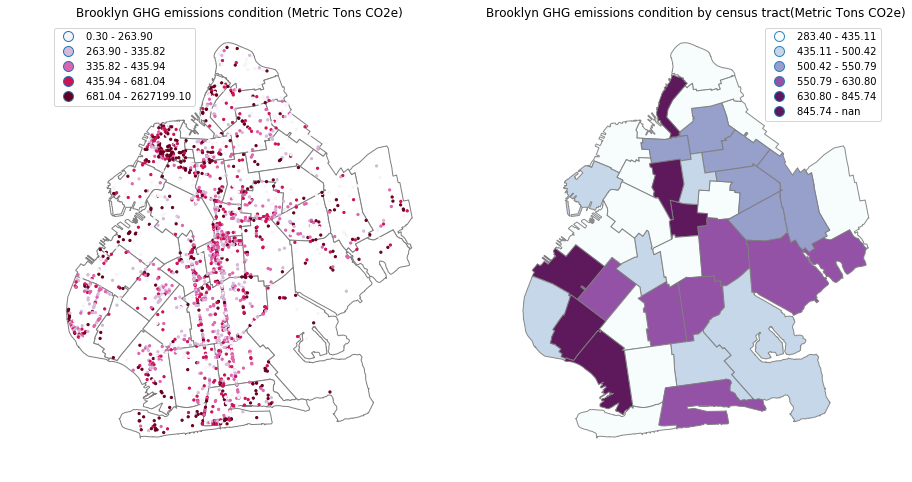

In [825]:
fig = pl.figure(figsize=(15,8)) 
ax = fig.add_subplot(121)
bkbasemap.plot(ax=ax,color='white',edgecolor='grey')
bkghgtotal.plot(column = 'GHG_Total',markersize=5,cmap='PuRd',scheme='quantiles',k=5,legend=True,ax=ax)

ax.axis('off')
ax.set_title('Brooklyn GHG emissions condition (Metric Tons CO2e)')

ax=fig.add_subplot(122)
censusmean.plot(column='GHG_Total',scheme='quantiles',k=6,legend=True,ax=ax,cmap='BuPu',edgecolor='grey',alpha=0.9)
ax.axis('off')
ax.set_title('Brooklyn GHG emissions condition by census tract(Metric Tons CO2e)')

Text(0,0.5,'GHG Emission (Metric Tons CO2e)')

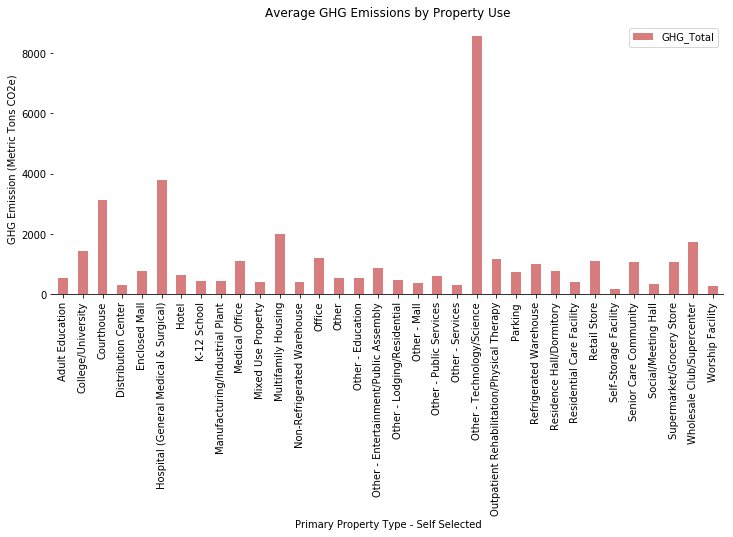

In [858]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(111)

bkghgtotal.groupby('Primary Property Type - Self Selected').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax,alpha=0.8)
ax.set_title('Average GHG Emissions by Property Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_ylabel('GHG Emission (Metric Tons CO2e)')

In [844]:
plutobk = gpd.gpd.GeoDataFrame.from_file('data/BKPLUTO/plutobk.shp')

In [838]:
plutobk.borough.unique()

array(['QN', 'MN', 'BK'], dtype=object)

In [886]:
plutobk_ = plutobk[plutobk['borough']=='BK']

In [888]:
meanghgbbl = ghgtotal.groupby('BBL - 10 digits').mean()

In [889]:
meanghgbbl.reset_index(inplace=True)

In [892]:
bkmergedghg = plutobk_.merge(meanghgbbl,left_on = 'bbl',right_on='BBL - 10 digits',how='left')[['address', 'bbl', 'borough', 'builtfar', 'landuse', 'yearbuilt',
                                                                                               'Total GHG Emissions (Metric Tons CO2e)']]

In [893]:
#plot ghg emissions by landuse
bkmergedghg['landuse'] = bkmergedghg['landuse'].astype('float')

[Text(0,0,'One &Two Family Buildings'),
 Text(0,0,'Multi-Family Walk-Up Buildings'),
 Text(0,0,'Multi-Family Elevator Buildings'),
 Text(0,0,'Mixed Residential & Commercial Buildings'),
 Text(0,0,'Commercial & Office Buildings'),
 Text(0,0,'Industrial & Manufacturing'),
 Text(0,0,'Transportation & Utility'),
 Text(0,0,'Public Facilities & Institutions'),
 Text(0,0,'Open Space & Outdoor Recreation'),
 Text(0,0,'Parking Facilities'),
 Text(0,0,'Vacant Land')]

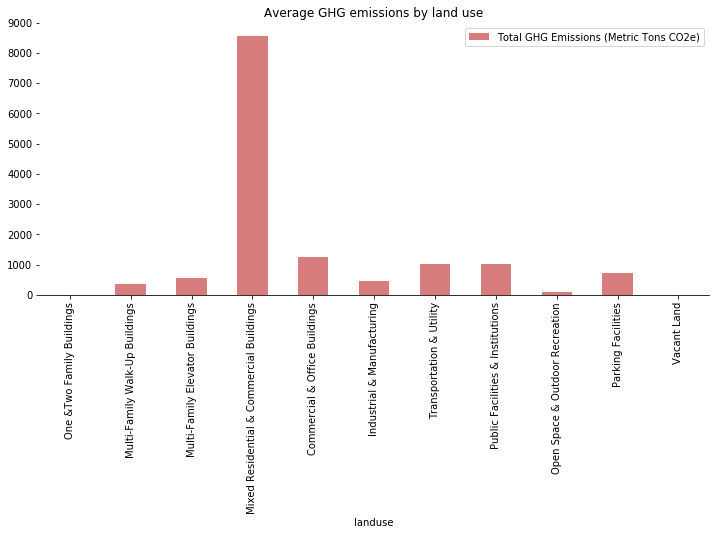

In [895]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
bkmergedghg.groupby('landuse').mean()[['Total GHG Emissions (Metric Tons CO2e)']].plot(kind='bar',color='IndianRed',ax=ax,alpha=0.8)
ax.set_title('Average GHG emissions by land use')
ax.set_xticklabels(['One &Two Family Buildings','Multi-Family Walk-Up Buildings','Multi-Family Elevator Buildings', 'Mixed Residential & Commercial Buildings',
                    'Commercial & Office Buildings', 'Industrial & Manufacturing', 'Transportation & Utility','Public Facilities & Institutions',
                    'Open Space & Outdoor Recreation','Parking Facilities','Vacant Land'])

In [900]:
farghg = bkmergedghg[bkmergedghg['Total GHG Emissions (Metric Tons CO2e)']<500000]
farghg.dropna(subset=['Total GHG Emissions (Metric Tons CO2e)'],inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Text(0.5,1,'GHG Emissions vs Built FAR')

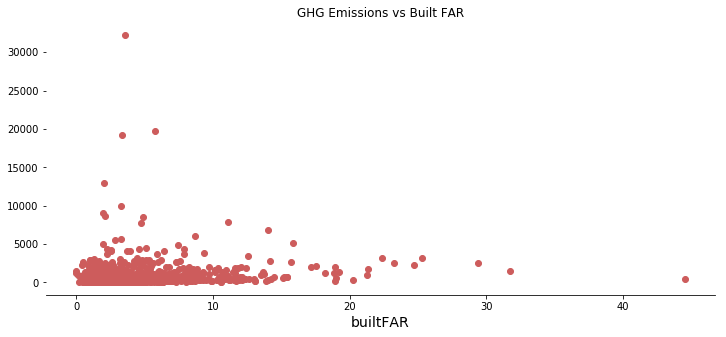

In [902]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(111)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.scatter(farghg['builtfar'],farghg['Total GHG Emissions (Metric Tons CO2e)'],color='IndianRed')
ax.set_xlabel('builtFAR',fontsize=14)
ax.set_title('GHG Emissions vs Built FAR')

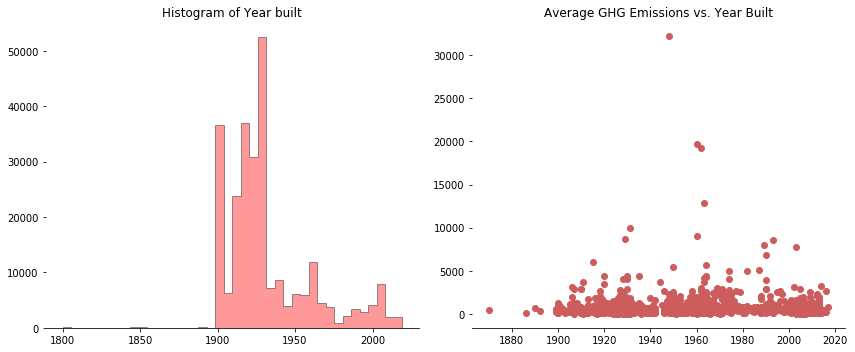

In [921]:
fig = pl.figure(figsize=(12,5)) 
ax = fig.add_subplot(121)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

kwargs = dict(histtype='stepfilled', alpha=0.4, density=False, bins=40, edgecolor = 'black',color='Red')

yearbuilt = bkmergedghg[bkmergedghg['yearbuilt']>1750]

ax.hist(yearbuilt['yearbuilt'], **kwargs)
ax.set_title('Histogram of Year built')

ax= fig.add_subplot(122)
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
yearbuilt2 = yearbuilt[yearbuilt['Total GHG Emissions (Metric Tons CO2e)']<500000]

ax.scatter(yearbuilt2['yearbuilt'],yearbuilt2['Total GHG Emissions (Metric Tons CO2e)'],color='IndianRed')
ax.set_title('Average GHG Emissions vs. Year Built')

pl.tight_layout()

## 3. GHG EMISSIONS SITUATION MAP IN STUDY AREA

### 3.1 Define the scope 

In [391]:
from zipfile import ZipFile
zf = ZipFile('data/draw_scope1.zip', 'r')
zf.extractall('data')
zf.close()

In [392]:
basemap = gpd.GeoDataFrame.from_file('data/pluto.shp')

Text(0.5,1,'The study area')

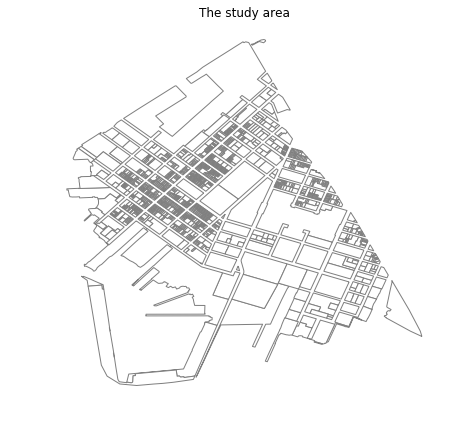

In [826]:
fig = pl.figure(figsize=(7,7)) 
ax = fig.add_subplot(111)
basemap.plot(color='white',edgecolor='grey',ax=ax)
ax.axis('off')
ax.set_title('The study area')

In [432]:
bkghgtotal.dropna(subset=['BBL - 10 digits'],axis=0,inplace=True)

In [544]:
basebbl = basemap[['bbl','zipcode','bldgarea', 'bldgclass', 'block', 'borough',
        'builtfar', 'commfar', 'factryarea', 'landuse',
        'numfloors', 'residfar']]
merge2 = basebbl.merge(bkghgtotal,left_on = 'bbl',right_on='BBL - 10 digits',how='inner')

In [545]:
merge2.shape

(15, 40)

### 3.2 Exploration and Visulization

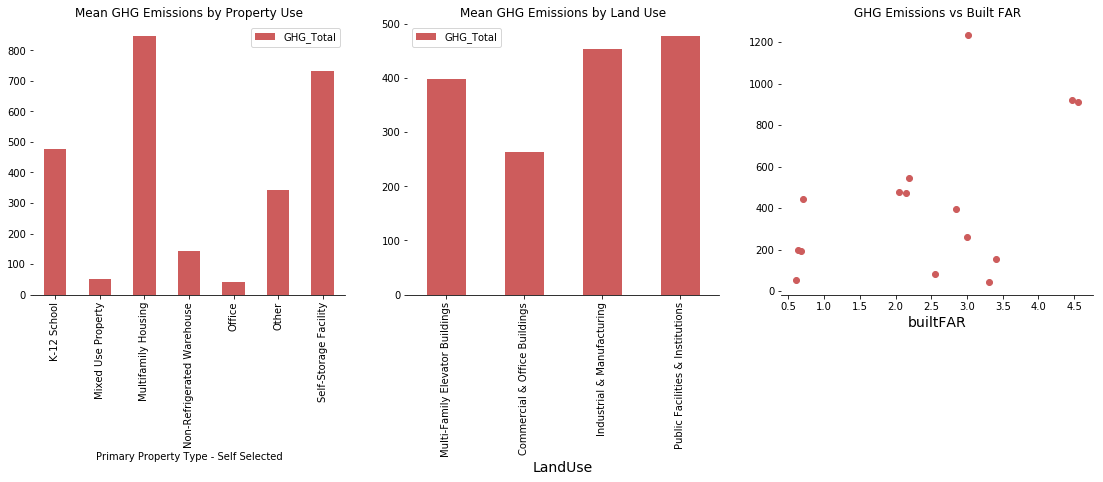

In [808]:
fig = pl.figure(figsize=(19,5)) 


ax = fig.add_subplot(131)
merge2.groupby('Primary Property Type - Self Selected').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax)
ax.set_title('Mean GHG Emissions by Property Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

ax=fig.add_subplot(132)
merge2.groupby('landuse').mean()[['GHG_Total']].plot(kind='bar',color='IndianRed',ax=ax)
ax.set_xlabel('LandUse',fontsize=14)
ax.set_xticklabels( ['Multi-Family Elevator Buildings','Commercial & Office Buildings','Industrial & Manufacturing','Public Facilities & Institutions'])
ax.set_title('Mean GHG Emissions by Land Use')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)


ax=fig.add_subplot(133)
ax.scatter(merge2['builtfar'],merge2['GHG_Total'],color='IndianRed')
ax.set_xlabel('builtFAR',fontsize=14)
ax.set_title('GHG Emissions vs Built FAR')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)



In [559]:
basemap['landuse'] = basemap['landuse'].astype(float)

In [497]:
areaghg = gpd.GeoDataFrame(merge2)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/geopandas/plotting.py:389: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "'color'.", UserWarning)


Text(0.5,1,'Distribuiton of GHG Emissions in study area')

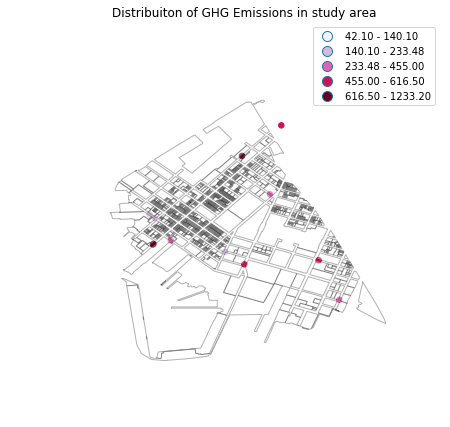

In [827]:
fig = pl.figure(figsize=(7,7)) 
ax = fig.add_subplot(111)
areaghg.plot(ax=ax,column='GHG_Total',marker='o',
             markersize=30, cmap="PuRd",legend=True,scheme='quantiles')
basemap.plot(column='builtfar',color='white',edgecolor='black',ax=ax,alpha=0.3)
ax.axis('off')
ax.set_title('Distribuiton of GHG Emissions in study area')

In [757]:
bblgroup = merge2.groupby('bbl').mean()[['GHG_Total']]
bblgroup.reset_index(inplace=True)

In [758]:
bblmap = basemap.merge(bblgroup,left_on='bbl',right_on='bbl',how='left')

In [803]:
landusegroup = merge2.groupby('landuse').mean()[['GHG_Total']]
landusegroup.reset_index(inplace=True)
landusegroup['landuse'] = [3.0,5.0,6.0,8.0]
landusegroup.dtypes

landuse      float64
GHG_Total    float64
dtype: object

In [752]:
landusemap = basemap.merge(landusegroup,on='landuse',how='left')

,zipcode,bbl,bldgarea,bldgclass,block,borough,bsmtcode,builtfar,address,commfar,factryarea,landuse,numbldgs,numfloors,ownertype,residfar,comarea,geometry,GHG_Total
0,11231,3.005080e+09,7800,F5,508,BK,0,2.02,62 SEABRING STREET,1.0,7800,6.0,1,1.0,None,0.00,7800,POLYGON ((-74.00701552412471 40.68144521404673...,453.42
1,11231,3.005130e+09,0,G6,513,BK,0,0.00,COLES STREET,1.0,0,10.0,0,0.0,None,0.00,0,"POLYGON ((-74.004583082609 40.6795176723404, -...",NaN
2,11231,3.005640e+09,2260,B9,564,BK,2,1.14,155 SULLIVAN STREET,2.0,0,1.0,1,2.0,None,0.00,0,POLYGON ((-74.01449387920651 40.67925263171069...,NaN
3,11231,3.005000e+09,0,V9,500,BK,5,0.00,92 HAMILTON AVENUE,2.0,0,11.0,0,0.0,C,0.00,0,POLYGON ((-74.00638872919973 40.68379790565796...,NaN
4,11231,3.002810e+09,6300,Y7,281,BK,0,0.08,1 SACKETT STREET,2.0,0,7.0,1,1.0,C,0.00,6300,"POLYGON ((-74.0068695331429 40.68646152566741,...",NaN
5,11231,3.004810e+09,20300,O7,481,BK,2,4.00,561 COURT STREET,1.0,0,5.0,1,4.0,None,0.00,20300,POLYGON ((-74.00001070627745 40.67357221783679...,262.80
6,11231,3.004840e+09,10000,G1,484,BK,0,1.00,571 COURT STREET,1.0,0,10.0,1,1.0,None,0.00,10000,"POLYGON ((-73.9999671980847 40.67281350595803,...",NaN
7,11231,3.004840e+09,10000,G1,484,BK,0,1.00,563 COURT STREET,1.0,0,10.0,1,1.0,None,0.00,10000,POLYGON ((-73.99984380397771 40.67306985729451...,NaN
8,11231,3.004840e+09,0,Z9,484,BK,0,0.00,222 BUSH STREET,1.0,0,NaN,1,4.0,None,0.00,0,POLYGON ((-73.99970358571038 40.67303015510898...,NaN
9,11231,3.004840e+09,0,Z9,484,BK,0,0.00,378 HAMILTON AVENUE,1.0,0,NaN,1,4.0,None,0.00,0,POLYGON ((-73.99963582814681 40.67296921615677...,NaN


(-74.021131370068886,
 -73.995436575082564,
 40.663591932758727,
 40.687625622401363)

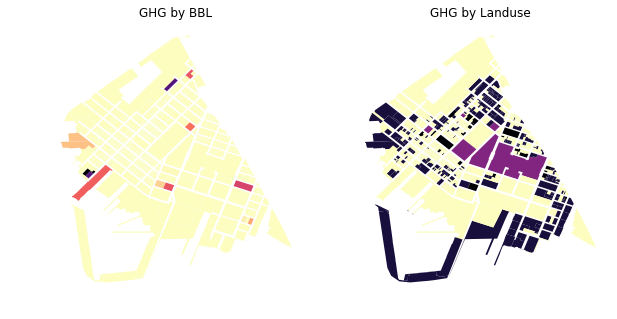

In [766]:
fig = pl.figure(figsize=(10,5)) 

ax = fig.add_subplot(121)
bblmap.plot(column='GHG_Total',cmap='magma_r',ax=ax,edgecolor=None)
ax.axis('off')
ax.set_title('GHG by BBL')


ax = fig.add_subplot(122)
landusemap.plot(column='GHG_Total',cmap='magma_r',edgecolor=None,ax=ax)
ax.set_title('GHG by Landuse')
ax.axis('off')


In [777]:
landusegroup['Landeuse_2'] = ['Multi-Family Elevator Buildings','Commercial & Office Buildings','Industrial & Manufacturing','Public Facilities & Institutions']
landusegroup

,landuse,GHG_Total,Landeuse_2
0,3.0,397.90,Multi-Family Elevator Buildings
1,5.0,262.80,Commercial & Office Buildings
2,6.0,453.42,Industrial & Manufacturing
3,8.0,477.70,Public Facilities & Institutions


Since the study area has very few ghg emissions data, I plan to use the Brooklyn ghg emissions current condition to do next step prediction.